<h1> unsupervised learning using Kmeans</h1>
various imports

In [9]:
import tensorflow as tf

from sklearn.cluster import KMeans
import numpy as np
from tensorflow.keras.applications import VGG16
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix


import seaborn as sns
import pickle
import os

In [10]:
# Load pre-trained VGG16 model + higher level layers

base_model = VGG16(weights='imagenet', include_top=True)


select feature extraction method

In [11]:
from feature_exteactor import VGG16_features

function to visualize and extract features

images_dataset/apple fruit\Image_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
numfilters 128
filtersize 112


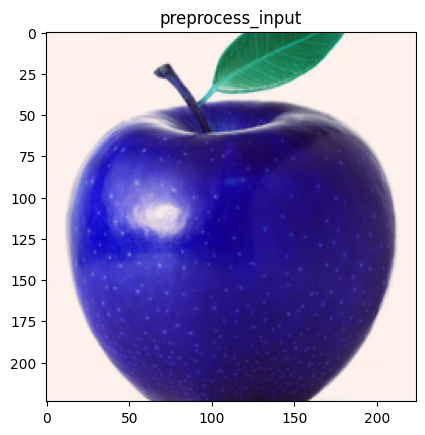

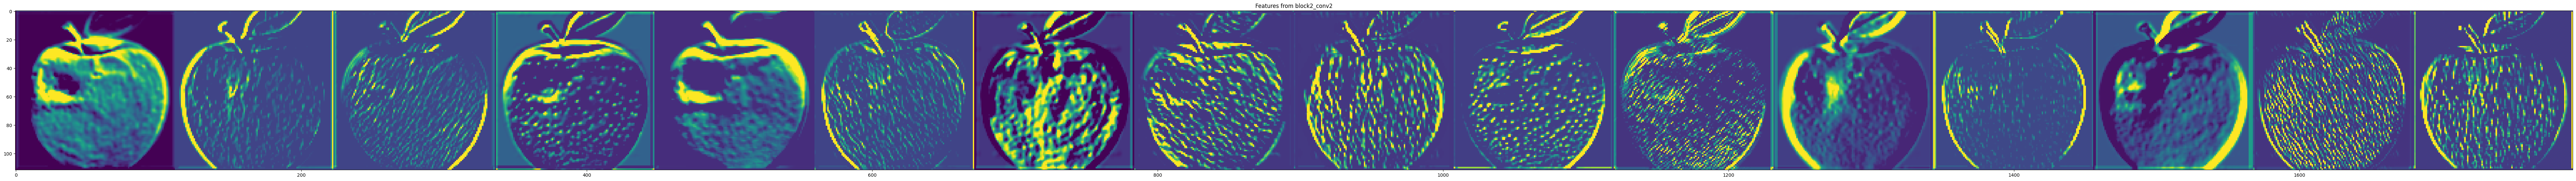

images_dataset/apple fruit\Image_10.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
numfilters 128
filtersize 112


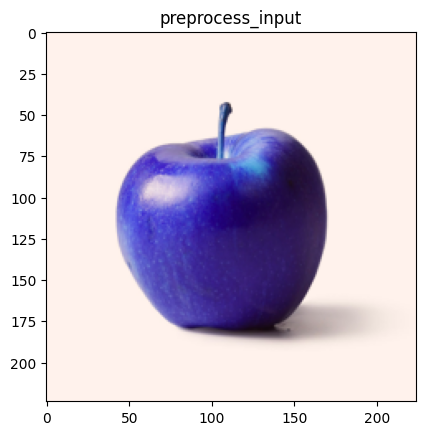

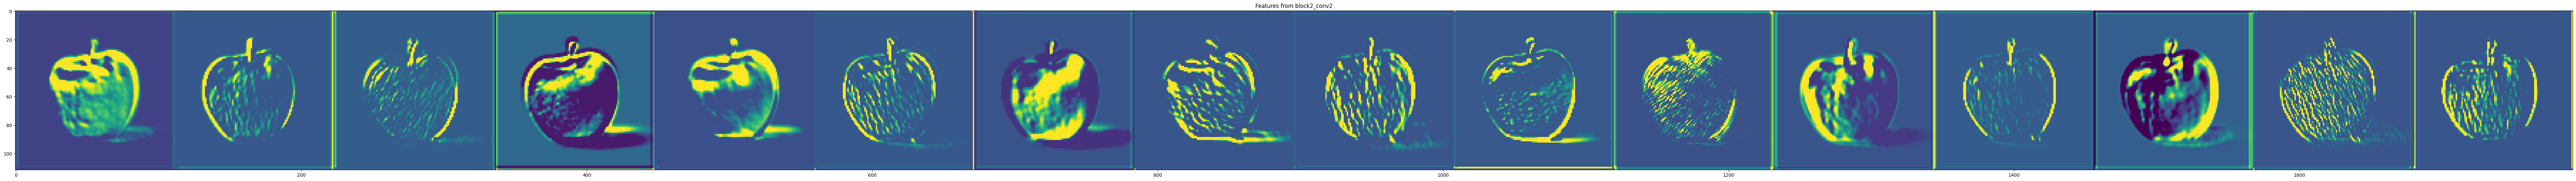

images_dataset/apple fruit\Image_11.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
numfilters 128
filtersize 112


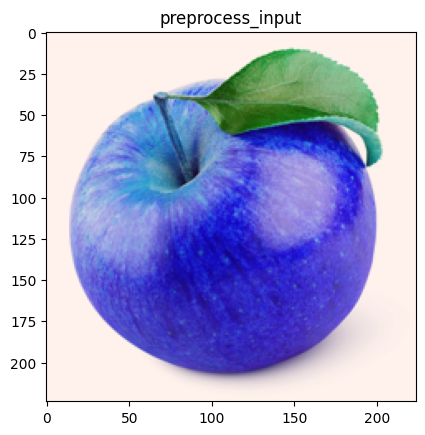

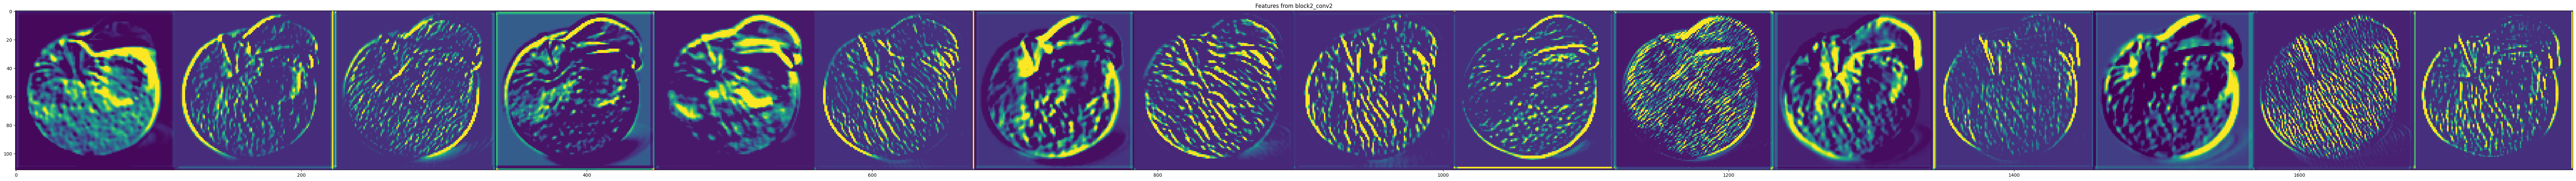

images_dataset/apple fruit\Image_12.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
numfilters 128
filtersize 112


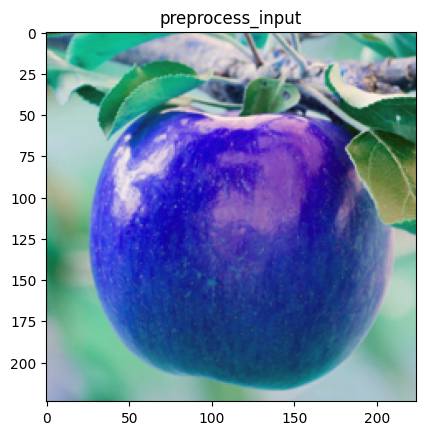

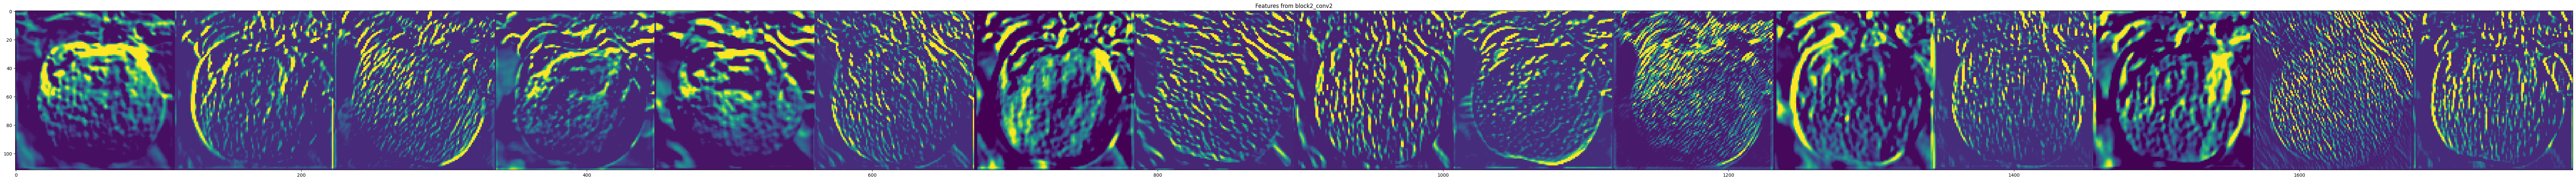

images_dataset/apple fruit\Image_13.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
numfilters 128
filtersize 112


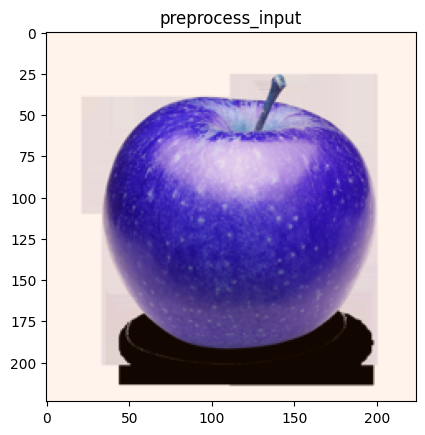

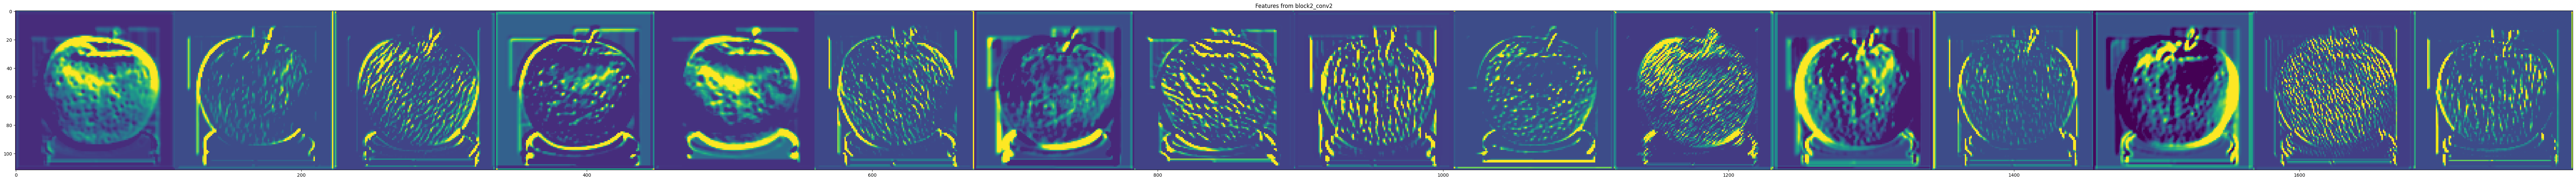

images_dataset/apple fruit\Image_14.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
numfilters 128
filtersize 112


KeyboardInterrupt: 

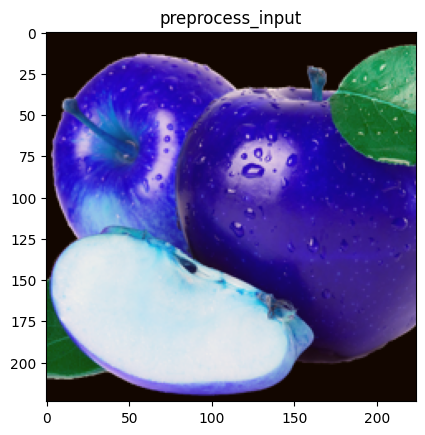

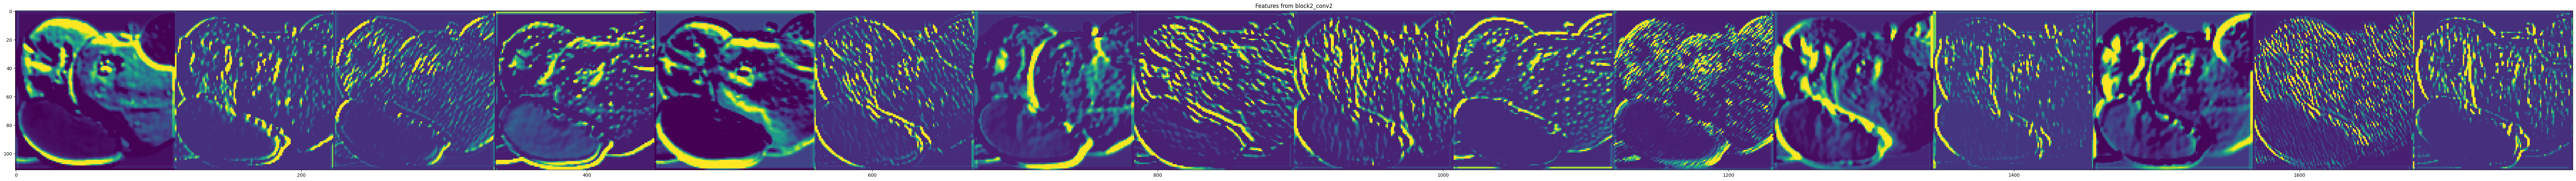

In [13]:
# Example usage
#features = VGG16_features('images_dataset/apple fruit/image_26.jpg', base_model, layer_name='block4_conv3',visualize=False)
#print("Extracted Features Shape:", features.shape)

#Existing layers are: ['input_1', 'block1_conv1-2', 'block1_pool', 'block2_conv1-2', 'block2_pool',
#'block3_conv1-2-3', 'block3_pool', 'block4_conv1-2-3', 'block4_pool', 'block5_conv1-2-3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'predictions'].

feature_list1=[]
eval_image_names=[]
labels= np.array([],dtype=int)
dirs_visited=[]
img_dir='images_dataset/'
k=0
for root, dirs, files in os.walk(img_dir):
    dirs_visited.append(root)
    for filename in files:
        img_path= os.path.join(root,filename)
        print(img_path)
        features = VGG16_features(img_path, base_model, layer_name='fc2',visualize=False)
        feature_list1.append(features)
        eval_image_names.append(img_path)
        labels=np.append(labels,k)
    k=k+1
    #del img_path, root, dirs, files

feature_list1 = np.array(feature_list1)
eval_image_names = np.array(eval_image_names)
dirs_visited = np.array(dirs_visited)


with open('features_labels.pkl', 'wb') as f:
    pickle.dump((feature_list1, eval_image_names, labels,dirs_visited), f)

    

features file loading 

In [ ]:
with open('features_labels.pkl', 'rb') as f:
    feature_list1, eval_image_names, labels, dirs_visited= pickle.load(f)


<h2>model Kmeans training, with PCA reduced features</h2>
(labels are included for evaluation of accuracy)

In [ ]:

print("array1 features",feature_list1.shape)


#pca component extraction mantaining 90% of test variance

pca= PCA()
pca.fit(feature_list1)
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
pca_components=np.argmax(cumulative_explained_variance>0.70)+1
print(f"Number of PCA components explaining 95% of variance: {pca_components}")
#applying pca with selected components number
pca = PCA(n_components=pca_components)
pca_result = pca.fit_transform(feature_list1)



#feature reduction 2D using tsne (for visualization only)
tsne = TSNE(n_components=2)
tsne_result=tsne.fit_transform(pca_result)


#Kmeans clustering using PCA reduced features
Kmeans= KMeans(n_clusters=9,init='k-means++')
Kmeans.fit(pca_result)
Kmeans_labels=Kmeans.labels_


#  Visualize the clustering results
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=Kmeans_labels, cmap='tab20c',s=9)
plt.title('t-SNE Visualization of Clusters')



#  Compare with true labels
plt.subplot(1,2,2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab20c',s=9)
plt.title('t-SNE Visualization with True Labels')

plt.show()


#clustering result
accuracy=adjusted_rand_score(Kmeans_labels,labels)
print("accuracy",accuracy)


#confusion matrix
conf_matrix = confusion_matrix(labels, Kmeans_labels)

#creating a dictionary that maps the "cluster labels" number to the most likely correct "true labels" number
row_ind, col_ind = linear_sum_assignment(-conf_matrix)
label_mapping = dict(zip(col_ind, row_ind))
mapped_Kmeans_labels = np.array([label_mapping[label] for label in Kmeans_labels])
remapped_conf_matrix = confusion_matrix(labels, mapped_Kmeans_labels)
#retrieve class names from the path discovery at beginning
dirs_basename= [os.path.basename(d) for d in dirs_visited]

# Visualize the remapped confusion matrix using a heatmap
sns.heatmap(remapped_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dirs_basename[1:len(dirs_basename)],
            yticklabels=dirs_basename[1:len(dirs_basename)])
plt.xlabel('Cluster Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

missed_images=[]
missed_indices= np.where(labels != mapped_Kmeans_labels)[0]
missed_images = eval_image_names[missed_indices]


print("Misclassified Images:")
for img in missed_images:
    print(img)

if 'features' in globals():
    del features

#if 'feature_list1' in globals():
 #   del feature_list1

AttributeError: 'list' object has no attribute 'shape'

<h2>model evaluation</h2>

In [ ]:
img_dir2='eval_dataset/'
dirs_visited=[]
eval_features=[]
eval_image_names=[]
for root, dirs, files in os.walk(img_dir2):
    dirs_visited.append(root)
    for filename in files:
        img_path= os.path.join(root,filename)
        print(img_path)
        features = VGG16_features(img_path, base_model, layer_name='fc2',visualize=False)
        eval_features.append(features)
        eval_image_names.append(img_path)


eval_features = np.array(eval_features)
eval_image_names = np.array(eval_image_names)
eval_image_names= [os.path.basename(d) for d in eval_image_names]


print('feature list shape', eval_features.shape)

#apply transformation matrix of PCA, previously calculated, to reduce feature vector size
eval_features= pca.transform(eval_features)

print('reduced feature list shape', eval_features.shape)



pred_clusters=Kmeans.predict(eval_features)
print('predicted cluster',pred_clusters)

mapped_Kmeans_labels = np.array([label_mapping[label] for label in pred_clusters])
print('mapped predicted cluster',mapped_Kmeans_labels)

for a in range(len(mapped_Kmeans_labels)):
    print('real name:',eval_image_names[a], '   predicted name:', dirs_basename[mapped_Kmeans_labels[a]])



eval_dataset/Apples.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
eval_dataset/eval_apple (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
eval_dataset/eval_apple (22).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
eval_dataset/eval_apple (23).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
eval_dataset/eval_apple (24).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
eval_dataset/eval_apple (25).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
eval_dataset/eval_apple (26).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
eval_dataset/eval_apple (27).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
eval_dataset/eval_apple (28).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
eval_dataset/eval_apple (29).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
eval_dataset/eval_apple (30).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
eval_dataset/eval_apple (31).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
eval_dataset/fresh-orange-fruit.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
eval_dataset/green-apple.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
ev